In [1]:
import torch
from torch import nn
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
batch_size = 64

### Data Load

In [3]:
trfs = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=trfs)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
def plot_batch(x_batch, y_batch):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(y_batch[i].numpy())
        image = x_batch[i].squeeze().numpy()
        plt.imshow(image, cmap='gray')
    plt.tight_layout()    

In [5]:
x_batch, y_batch = next(iter(dataloader))
x_batch.shape, y_batch.shape, x_batch[0].max(), x_batch[0].min()

(torch.Size([64, 1, 28, 28]), torch.Size([64]), tensor(1.), tensor(0.))

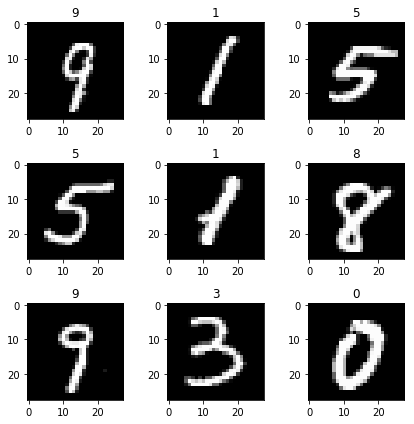

In [6]:
plot_batch(x_batch, y_batch)

### Model

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.encoder(x)
        y = self.decoder(y)
        return y.view(-1, 1, 28, 28)

### Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
%%time
n_epochs = 100
ae = Autoencoder()
ae = ae.to(device)
optimizer = optim.Adam(ae.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
dataset_size = len(dataset)

for e in range(n_epochs):
    epoch_loss = 0.0
    for inputs,_ in dataloader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = ae(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    if e % 10 == 9:
        print(f'[{(e+1):3d}/{n_epochs}] '
              f'loss: {(epoch_loss/dataset_size):.3f}')


[ 10/100] loss: 0.036
[ 20/100] loss: 0.035
[ 30/100] loss: 0.034
[ 40/100] loss: 0.034
[ 50/100] loss: 0.033
[ 60/100] loss: 0.033
[ 70/100] loss: 0.033
[ 80/100] loss: 0.032
[ 90/100] loss: 0.032
[100/100] loss: 0.032
CPU times: user 11min 20s, sys: 43.5 s, total: 12min 3s
Wall time: 12min 12s


In [10]:
torch.save(ae.state_dict(), 'ae.pth')

### Reconstruction

In [11]:
ae = Autoencoder()
ae = ae.to(device)
ae.load_state_dict(torch.load('ae.pth'))

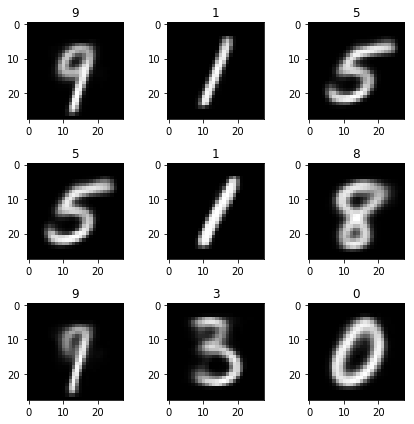

In [12]:
ae.eval()
imgs = x_batch.to(device)
decode_imgs = ae(imgs)
plot_batch(decode_imgs.detach().cpu(), y_batch)

### Evaluate Latent Space

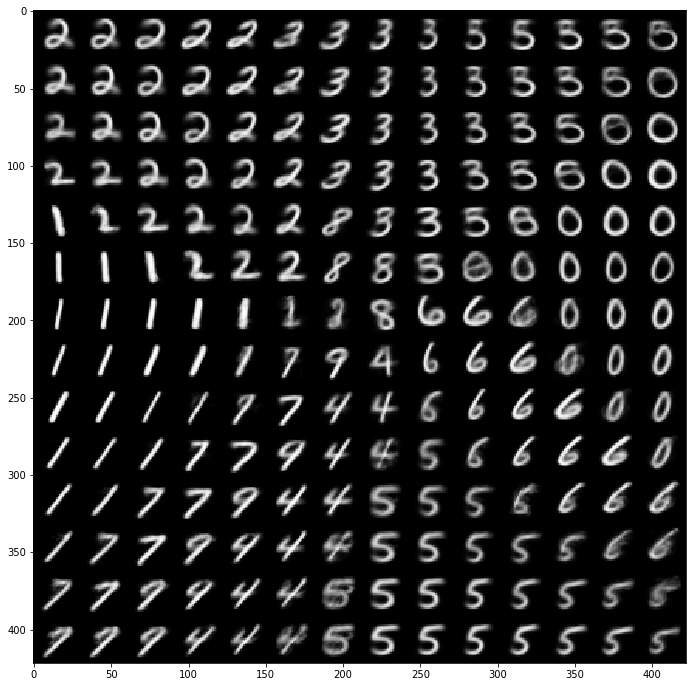

In [14]:
import itertools
from torchvision.utils import make_grid
samples = torch.tensor([i for i in itertools.product(torch.arange(-10, 10, 1.5), repeat=2)])
samples = samples.to(device)
samples_imgs = ae.decoder(samples)
samples_imgs = samples_imgs.view(samples_imgs.size(0), 1, 28, 28).detach().cpu()
grid_img = make_grid(samples_imgs, 14)
grid_img = grid_img.numpy().transpose(1,2,0)
plt.figure(figsize=(12, 12))
plt.imshow(grid_img);